In [4]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch

from train import train_MSAP
from dist_matrix import gen_dist_matrix

import matplotlib.pyplot as plt
plt.rcParams["font.size"] = 15

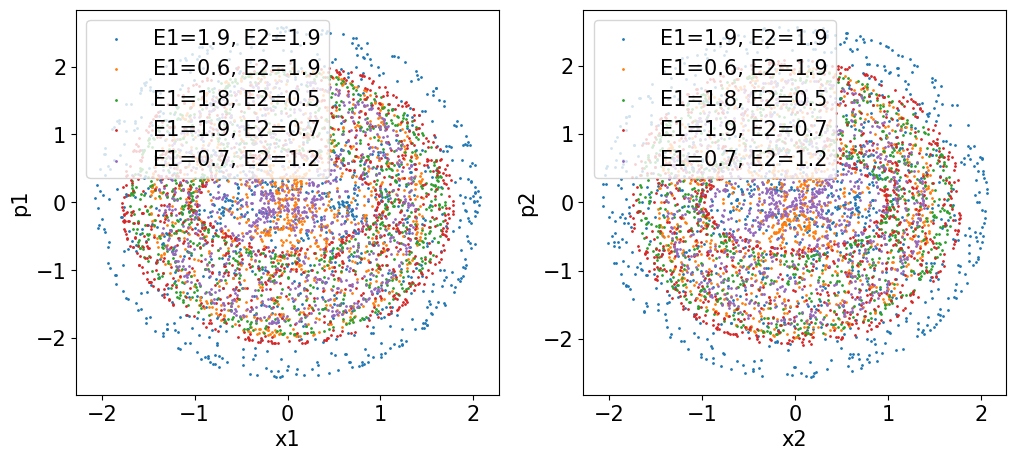

In [12]:
co = np.load("data/coupled_oscillator.npz")

data = co["data"]
E = co["E"]

idx = np.random.choice(range(len(data)), size=5)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for i in [0, 1]:
    for j in idx:
        axes[i].scatter(*data[j][:, [i, i + 2]].T, s=1, label=f"E1={round(E[j][0], 1)}, E2={round(E[j][1], 1)}")
    axes[i].set_xlabel(f"x{i + 1}")
    axes[i].set_ylabel(f"p{i + 1}")
    axes[i].legend()

plt.savefig("graphs/co_traj.pdf")

plt.show()

In [3]:
# data = StandardScaler().fit_transform(data.reshape(data.shape[0] * data.shape[1], -1)).reshape(data.shape)
# dmat = gen_dist_matrix(data, name="data/co")
dmat = np.load("data/co_dmat.npz")["dmat"]

valid_size = len(dmat) // 5
train_size = len(dmat) - valid_size

train_idx, valid_idx = train_test_split(torch.arange(len(dmat)), test_size=valid_size)

dmat = torch.tensor(dmat, dtype=torch.float32)
train_dmat = dmat[train_idx[:, None], train_idx[None, :]]
valid_dmat = dmat[valid_idx[:, None], train_idx[None, :]]

In [ ]:
cfg = {
    "target_dim": 10,
    "intermediate_dim": 16,
    "intermediate_layers": 2,
}

models_co, losses_co = train_MSAP(train_dmat, valid_dmat, cfg, "co", min_delta=0.1, patience=50, project_name="MSAP", N_inits=2)

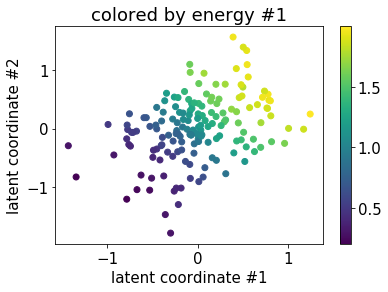

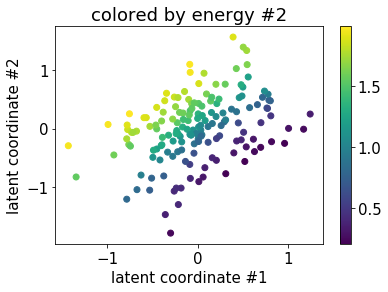

In [5]:
model2d = models_co[1]
for i in [0, 1]:
    plt.figure()
    plt.scatter(*model2d.latent.cpu().detach().T, c=E[train_idx, i])
    plt.xlabel(f"latent coordinate #1")
    plt.ylabel(f"latent coordinate #2")
    plt.colorbar()
    plt.title(f"colored by energy #{i + 1}")
    plt.savefig(f"graphs/co_latent_E{i + 1}.pdf")

plt.show()

In [ ]:
# to plot this graph you have to download the validation loss data from the wandb to the data folder


import pandas as pd
from matplotlib.lines import Line2D

learning_curves = pd.read_csv("data/co_learning_curves.csv")

plt.figure(figsize=(8, 5))
epoch = learning_curves["epoch"]
for i in range(1, 5):
    c = "green" if i == 2 else ("red" if i == 1 else "black")
    alpha = 1 if i <= 2 else 0.2
    for init in range(1, 3):
        valid_loss = learning_curves[f"co; latent_dim: {i}, init #{init} - valid_loss"]
        plt.plot(epoch, valid_loss, c=c, alpha=alpha)

custom_lines = [Line2D([0], [0], color="red", lw=1),
                Line2D([0], [0], color="green", lw=1),
                Line2D([0], [0], color="gray", lw=1)]

plt.legend(custom_lines, ["k = 1", "k = 2", "k > 1"])

plt.ylim(0, 0.02)

plt.xlabel("epoch")
plt.ylabel("validation loss")

plt.savefig("graphs/co_learning_curves.pdf")

plt.show()